## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5, 0.9]
redice_lr_patient = [5,9]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 3s 53us/step - loss: 1.6708 - acc: 0.4193 - val_loss: 1.7578 - val_acc: 0.3939
Epoch 14/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.6547 - acc: 0.4226 - val_loss: 1.7418 - val_acc: 0.3969
Epoch 15/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.6397 - acc: 0.4294 - val_loss: 1.7323 - val_acc: 0.4011
Epoch 16/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.6258 - acc: 0.4358 - val_loss: 1.7206 - val_acc: 0.4057
Epoch 17/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.6123 - acc: 0.4391 - val_loss: 1.7111 - val_acc: 0.4101
Epoch 18/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5993 - acc: 0.4432 - val_loss: 1.7023 - val_acc: 0.4118
Epoch 19/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5879 - acc: 0.4475 - val_loss: 1.6957 - val_acc: 0.4141
Epoch 20/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 72us/step - loss: 2.7438 - acc: 0.1548 - val_loss: 2.8159 - val_acc: 0.1962
Epoch 2/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.2510 - acc: 0.2575 - val_loss: 2.2725 - val_acc: 0.2669
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.0756 - acc: 0.2981 - val_loss: 2.1182 - val_acc: 0.2945
Epoch 4/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.9778 - acc: 0.3242 - val_loss: 2.0132 - val_acc: 0.3185
Epoch 5/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.9108 - acc: 0.3422 - val_loss: 1.9538 - val_acc: 0.3308
Epoch 6/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.8618 - acc: 0.3554 - val_loss: 1.9094 - val_acc: 0.3437
Epoch 7/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.8208 - acc: 0.3685 - val_loss: 1.8741 - val_acc

50000/50000 [==============================] - 3s 53us/step - loss: 1.5409 - acc: 0.4635 - val_loss: 1.6675 - val_acc: 0.4189
Epoch 25/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5316 - acc: 0.4671 - val_loss: 1.6608 - val_acc: 0.4189
Numbers of exp: 5, reduce_factor: 0.90, reduce_patient: 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizatio

D:\anaconda\envs\tensorflow_gpu\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109587). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 3s 55us/step - loss: 1.5708 - acc: 0.4517 - val_loss: 1.6841 - val_acc: 0.4116
Epoch 22/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5599 - acc: 0.4552 - val_loss: 1.6791 - val_acc: 0.4120
Epoch 23/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5506 - acc: 0.4575 - val_loss: 1.6724 - val_acc: 0.4139
Epoch 24/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5411 - acc: 0.4611 - val_loss: 1.6664 - val_acc: 0.4184
Epoch 25/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5310 - acc: 0.4644 - val_loss: 1.6597 - val_acc: 0.4188
Numbers of exp: 6, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________


50000/50000 [==============================] - 3s 60us/step - loss: 1.5347 - acc: 0.4671 - val_loss: 1.6417 - val_acc: 0.4327
Epoch 8/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.5095 - acc: 0.4752 - val_loss: 1.6267 - val_acc: 0.4359
Epoch 9/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.4873 - acc: 0.4838 - val_loss: 1.6138 - val_acc: 0.4417
Epoch 10/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4675 - acc: 0.4914 - val_loss: 1.6046 - val_acc: 0.4421
Epoch 11/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4509 - acc: 0.4953 - val_loss: 1.5953 - val_acc: 0.4478
Epoch 12/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4330 - acc: 0.5020 - val_loss: 1.5886 - val_acc: 0.4497
Epoch 13/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4167 - acc: 0.5084 - val_loss: 1.5768 - val_acc: 0.4521
Epoch 14/25
50000/50000 [=======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 91us/step - loss: 2.1716 - acc: 0.2830 - val_loss: 2.0310 - val_acc: 0.3296
Epoch 2/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.7742 - acc: 0.3843 - val_loss: 1.8166 - val_acc: 0.3741
Epoch 3/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.6709 - acc: 0.4174 - val_loss: 1.7303 - val_acc: 0.4007
Epoch 4/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.6088 - acc: 0.4375 - val_loss: 1.6796 - val_acc: 0.4124
Epoch 5/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5642 - acc: 0.4528 - val_loss: 1.6532 - val_acc: 0.4218
Epoch 6/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5282 - acc: 0.4660 - val_loss: 1.6255 - val_acc: 0.4322
Epoch 7/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5004 - acc: 0.4774 - val_loss: 1.6201 - val_acc

50000/50000 [==============================] - 3s 59us/step - loss: 1.2710 - acc: 0.5646 - val_loss: 1.5296 - val_acc: 0.4667
Epoch 25/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2610 - acc: 0.5688 - val_loss: 1.5221 - val_acc: 0.4734
Numbers of exp: 11, reduce_factor: 0.90, reduce_patient: 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.0117 - acc: 0.6424 - val_loss: 1.8519 - val_acc: 0.3875
Epoch 13/25
50000/50000 [==============================] - 3s 59us/step - loss: 0.9819 - acc: 0.6528 - val_loss: 2.3808 - val_acc: 0.3284
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.9511 - acc: 0.6691 - val_loss: 1.7769 - val_acc: 0.3929
Epoch 15/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.9226 - acc: 0.6766 - val_loss: 1.5320 - val_acc: 0.4704
Epoch 16/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.8921 - acc: 0.6886 - val_loss: 1.9419 - val_acc: 0.4020
Epoch 17/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.8609 - acc: 0.7006 - val_loss: 1.5960 - val_acc: 0.4732
Epoch 18/25
50000/50000 [==============================] - 3s 59us/step - loss: 0.8290 - acc: 0.7082 - val_loss: 1.6777 - val_acc: 0.4521
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.9542 - acc: 0.3298 - val_loss: 1.9583 - val_acc: 0.3476
Epoch 2/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.6317 - acc: 0.4310 - val_loss: 1.8995 - val_acc: 0.3550
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5187 - acc: 0.4705 - val_loss: 1.7225 - val_acc: 0.4151
Epoch 4/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4377 - acc: 0.5004 - val_loss: 1.7549 - val_acc: 0.4021
Epoch 5/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3753 - acc: 0.5196 - val_loss: 1.6257 - val_acc: 0.4393
Epoch 6/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3214 - acc: 0.5428 - val_loss: 1.5676 - val_acc: 0.4538
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2757 - acc: 0.5591 - val_loss: 1.6331 - val_acc

50000/50000 [==============================] - 3s 57us/step - loss: 1.1629 - acc: 0.6067 - val_loss: 1.5073 - val_acc: 0.4792
Epoch 24/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1485 - acc: 0.6131 - val_loss: 1.4968 - val_acc: 0.4805
Epoch 25/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1341 - acc: 0.6185 - val_loss: 1.4967 - val_acc: 0.4787
Numbers of exp: 16, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_laye

Epoch 11/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4069 - acc: 0.5160 - val_loss: 1.6088 - val_acc: 0.4365
Epoch 12/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3813 - acc: 0.5255 - val_loss: 1.5783 - val_acc: 0.4518
Epoch 13/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3580 - acc: 0.5332 - val_loss: 1.5720 - val_acc: 0.4497
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3357 - acc: 0.5415 - val_loss: 1.5667 - val_acc: 0.4509
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3153 - acc: 0.5480 - val_loss: 1.5476 - val_acc: 0.4570
Epoch 16/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2942 - acc: 0.5590 - val_loss: 1.5410 - val_acc: 0.4619
Epoch 17/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2758 - acc: 0.5649 - val_loss: 1.5440 - val_acc: 0.4625
Epoch 18/25
50000/50000 [=========

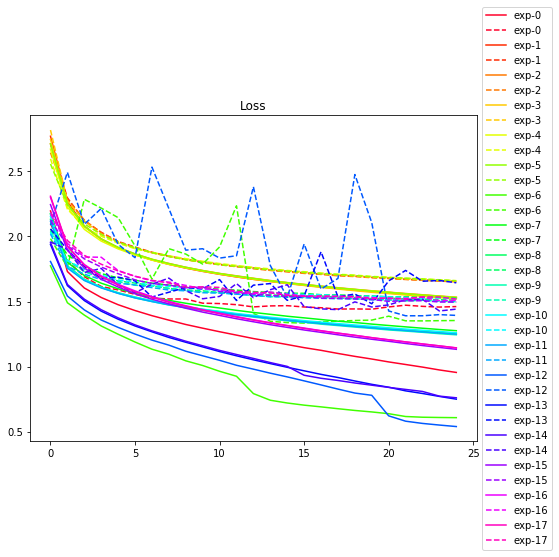

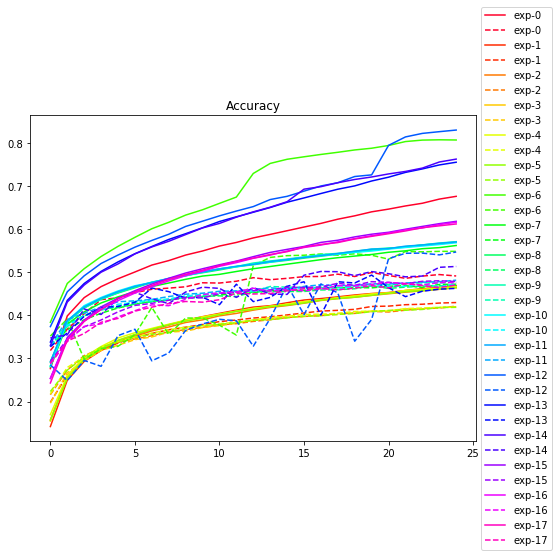

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()